## **Model Testing and Performance Evaluation**

This notebook tests four pre-trained models (**UNet**, **SEUNet**, **AttUNet**, **DualAttUNet**) on a given test dataset and evaluates their performance using various metrics. The results are saved in an Excel file with highlighted best and second-best values for each metric.

## **Steps**

1. **Configuration**
   - Device setup (CPU or GPU)
   - Batch size: 4
   - Test dataset path and result save path
   - Sequence length for evaluation

2. **Model and Weights**
   - Four models are loaded:
     - UNet
     - SEUNet
     - AttUNet
     - DualAttUNet
   - Corresponding pre-trained weights are provided for each model.

3. **Metrics**
   - The following metrics are computed:
     - **FAR (False Alarm Rate)**
     - **CSI (Critical Success Index)**
     - **HSS (Heidke Skill Score)**
     - **GSS (Gilbert Skill Score)**
     - **MSE (Mean Squared Error)**
     - **MAE (Mean Absolute Error)**
   - These metrics are evaluated at different rainfall intensity thresholds:  
     `>0.5, >2, >5, >10, >30`

4. **Results**
   - The computed metrics are saved in an Excel file.
   - The Excel file highlights:
     - **Lowest FAR values** (best and second-best) for each threshold.
     - **Highest CSI, HSS, GSS values** (best and second-best) for each threshold.

In [ ]:
import os
from pathlib import Path
from datetime import datetime

import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt  # For visualization

from models import UNet, SEUNet, DualAttUNet, AttUNet  # Import only necessary models
from evaluate import Evaluater
from TSDataset import TSDataset, ToTensor
from utils import *  # Import utility functions
from openpyxl.styles import Font

In [1]:
# Configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
amp = False  # Enable or disable Automatic Mixed Precision (AMP)
batch_size = 4  # Batch size
save_dir = '/home/sehoon/Desktop/측량학회/single_model_results'  # Directory to save results
test_data_path = "/home/sehoon/Desktop/측량학회/data/dataset_0.5_0.05_6_1_1/test/"  # Path to the test dataset
evaluater_seq_len = 1  # Sequence length for the Evaluater class

# List of pre-trained models and their corresponding weight paths
models = [
    ('UNet', UNet(n_channels=6, n_classes=1)),
    ('SEUNet', SEUNet(n_channels=6, n_classes=1)),
    ('AttUNet', AttUNet(n_channels=6, n_classes=1)),
    ('DualAttUNet', DualAttUNet(n_channels=6, n_classes=1))
]

model_paths = [
    "/home/sehoon/Desktop/측량학회/results/UNet_epochs=100_bs=4_lr=0.0001_20240922_173646_final_model.pth",
    ...
]

# Function to test models and save results
def test_model_and_save_results(model, test_data_path, device, amp_enabled, batch_size, model_name, evaluater_seq_len):
    test_set = TSDataset(Path(test_data_path), transform=ToTensor())
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, drop_last=False, pin_memory=(device.type == 'cuda'))
    
    evaluater = Evaluater(seq_len=evaluater_seq_len)

    # Model testing
    with torch.no_grad():
        for batch in tqdm(test_loader, desc=f"Testing {model_name}", unit="batch"):
            inputs, targets = batch['input'].to(device), batch['label'].to(device)
            with torch.amp.autocast('cuda', enabled=amp_enabled):
                predictions = model(inputs)
            evaluater.update(gt=targets.cpu().numpy(), pred=predictions.cpu().numpy())
    
    # Extract performance metrics (FAR, CSI, HSS, GSS)
    precision, recall, f1, far, csi, hss, gss, mse, mae = evaluater.print_stat_readable()
    return far, csi, hss, gss, mse, mae

# Define the structure of the dictionary to store results for each metric
performance_results = {
    'FAR': {">0.5": [], ">2": [], ">5": [], ">10": [], ">30": []},
    'CSI': {">0.5": [], ">2": [], ">5": [], ">10": [], ">30": []},
    'HSS': {">0.5": [], ">2": [], ">5": [], ">10": [], ">30": []},
    'GSS': {">0.5": [], ">2": [], ">5": [], ">10": [], ">30": []}
}

model_names = ["UNet", "SEUNet", "AttUNet", "DualAttUNet"]

mse_list = []
mae_list = []

# Extract performance metrics for each model and save results
for (model_name, model), model_path in zip(models, model_paths):
    model = torch.load(model_path, map_location=device)
    model.to(device)

    # Test the model and extract FAR, CSI, HSS, and GSS values
    far, csi, hss, gss, mse, mae = test_model_and_save_results(
        model=model,
        test_data_path=test_data_path,
        device=device,
        amp_enabled=amp,
        batch_size=batch_size,
        model_name=model_name,
        evaluater_seq_len=evaluater_seq_len
    )

    performance_results['FAR'][">0.5"].append(far[0, 0])
    performance_results['FAR'][">2"].append(far[0, 1])
    performance_results['FAR'][">5"].append(far[0, 2])
    performance_results['FAR'][">10"].append(far[0, 3])
    performance_results['FAR'][">30"].append(far[0, 4])

    performance_results['CSI'][">0.5"].append(csi[0, 0])
    performance_results['CSI'][">2"].append(csi[0, 1])
    performance_results['CSI'][">5"].append(csi[0, 2])
    performance_results['CSI'][">10"].append(csi[0, 3])
    performance_results['CSI'][">30"].append(csi[0, 4])

    performance_results['HSS'][">0.5"].append(hss[0, 0])
    performance_results['HSS'][">2"].append(hss[0, 1])
    performance_results['HSS'][">5"].append(hss[0, 2])
    performance_results['HSS'][">10"].append(hss[0, 3])
    performance_results['HSS'][">30"].append(hss[0, 4])

    performance_results['GSS'][">0.5"].append(gss[0, 0])
    performance_results['GSS'][">2"].append(gss[0, 1])
    performance_results['GSS'][">5"].append(gss[0, 2])
    performance_results['GSS'][">10"].append(gss[0, 3])
    performance_results['GSS'][">30"].append(gss[0, 4])

    mse_list.append(mse)
    mae_list.append(mae)

# Save results to an Excel file and apply formatting
save_path = "/home/sehoon/Desktop/측량학회/performance_results.xlsx"
with pd.ExcelWriter(save_path, engine='openpyxl') as writer:
    for metric in ['FAR', 'CSI', 'HSS', 'GSS']:
        # Convert results for each metric to a DataFrame
        metric_df = pd.DataFrame(performance_results[metric], index=model_names)
        
        # Save to Excel
        metric_df.to_excel(writer, sheet_name=f'{metric} Results')
        worksheet = writer.sheets[f'{metric} Results']

        # Apply styling for the smallest and second smallest values for each threshold
        for col in range(2, len(metric_df.columns) + 2):  # The first column is the index (model names), values start from the second column
            values = [metric_df.iloc[row, col - 2] for row in range(len(metric_df))]

            if metric == 'FAR':
                # For FAR, find the lowest and second lowest values
                min_idx = np.argmin(values)
                second_min_idx = np.argsort(values)[1]

                # Apply bold font to the lowest value
                worksheet.cell(row=min_idx + 2, column=col).font = Font(bold=True)

                # Apply underline to the second lowest value
                worksheet.cell(row=second_min_idx + 2, column=col).font = Font(underline="single")

            else:
                # For other metrics (CSI, HSS, GSS), apply styling to the highest values
                max_idx = np.argmax(values)
                second_max_idx = np.argsort(values)[-2]

                # Apply bold font to the highest value
                worksheet.cell(row=max_idx + 2, column=col).font = Font(bold=True)

                # Apply underline to the second highest value
                worksheet.cell(row=second_max_idx + 2, column=col).font = Font(underline="single")

print(f"Results saved at {save_path}")

/tmp/ipykernel_3195575/2371503531.py:71: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path, map_location=device)
Testing UNet: 100%|██████████| 229

Results saved at /home/sehoon/Desktop/측량학회/performance_results.xlsx


## **Visualization**

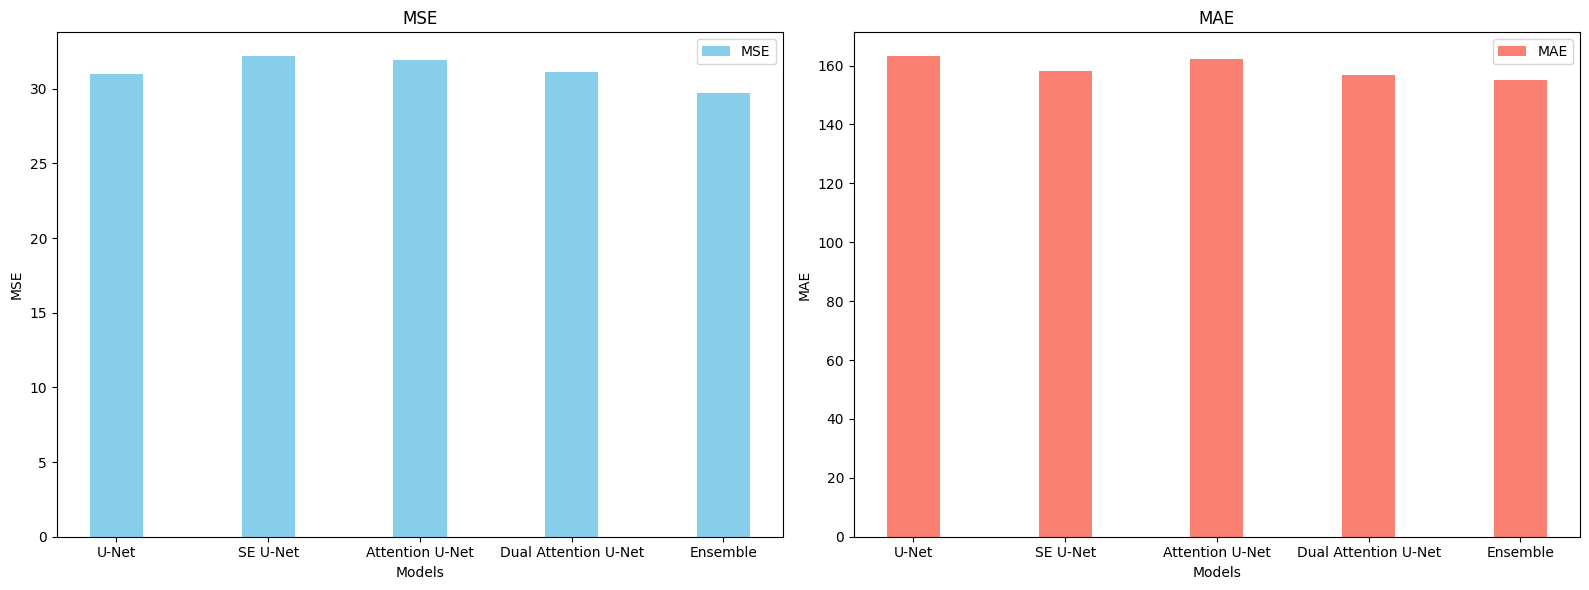

In [33]:
# Flatten and scale
mse_values = np.array([item.flatten()[0] for item in mse_list]) * 20000
mae_values = np.array([item.flatten()[0] for item in mae_list]) * 20000

# Append new values using np.append
mse_values = np.append(mse_values, 0.00148414936847985 * 20000)
mae_values = np.append(mae_values, 0.00775704858824611 * 20000)

# 모델 이름 설정
models = ["U-Net", "SE U-Net", "Attention U-Net", "Dual Attention U-Net", "Ensemble"]

# 바의 위치 설정
x = np.arange(len(models))

# 바의 너비 설정
width = 0.35

# 서브플롯 생성 (1행 2열)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# 첫 번째 서브플롯: MSE 차트
ax1.bar(x, mse_values, width, label='MSE', color='skyblue')
ax1.set_xlabel('Models')
ax1.set_ylabel('MSE')
ax1.set_title('MSE')
ax1.set_xticks(x)
ax1.set_xticklabels(models)
ax1.legend()

# 두 번째 서브플롯: MAE 차트
ax2.bar(x, mae_values, width, label='MAE', color='salmon')
ax2.set_xlabel('Models')
ax2.set_ylabel('MAE')
ax2.set_title('MAE')
ax2.set_xticks(x)
ax2.set_xticklabels(models)
ax2.legend()

# 플롯 간 간격 조정
plt.tight_layout()

# 플롯 표시
plt.show()

In [2]:
# 모델 이름 설정
models = ["U-Net", "SE U-Net", "Attention U-Net", "Dual Attention U-Net", "Ensemble"]

# Flatten and scale (assuming mse_list and mae_list are predefined)
mse_values = np.array([item.flatten()[0] for item in mse_list]) * 20000
mae_values = np.array([item.flatten()[0] for item in mae_list]) * 20000

# Append new values using np.append
mse_values = np.append(mse_values, 0.00148414936847985 * 20000)
mae_values = np.append(mae_values, 0.00775704858824611 * 20000)

# Create a DataFrame with the values
df = pd.DataFrame({
    'Model': models,
    'MSE': mse_values,
    'MAE': mae_values
})

## **Weighted Average Ensemble and Grid Search for Parameter Tuning**

In this study, a **weighted average ensemble** approach is used to combine the predictions from multiple models. The goal is to improve the overall performance by leveraging the strengths of different models. Additionally, **grid search** is employed to determine the optimal combination of weights for each model in the ensemble.

The best combination of weights is determined based on the performance metrics, and the results are saved in an Excel file. The following steps summarize the workflow:
1. Load pre-trained models and their weights.
2. Apply grid search to find the optimal set of weights.
3. Evaluate the ensemble performance using different metrics.
4. Save the results, including the optimal weights and corresponding performance, to an Excel file for further analysis.

In [55]:
def save_image(tensor, path):
    """
    Function to save a tensor as an image.
    """
    image = tensor.cpu().numpy()
    image = np.squeeze(image)  # Remove the channel dimension
    image = (image * 255).astype(np.uint8)  # Convert values in range 0-1 to 0-255
    Image.fromarray(image).save(path)


def visualize_and_save(inputs, targets, model_outputs, ensemble_predictions, input_names, pred_image_name, save_dir):
    """
    Function to visualize and save results as PNG images.

    Parameters:
        inputs: Model input image tensor (including batch size, 6 time steps)
        targets: Ground truth image tensor (including batch size)
        model_outputs: List of predicted images from each model (including batch size)
        ensemble_predictions: Tensor of ensemble prediction results (including batch size)
        input_names: List of input image filenames
        pred_image_name: Filename for prediction images
        save_dir: Directory to save the visualization results
    """
    batch_size = inputs.size(0)  # Get batch size
    n_channels = inputs.size(1)  # Get number of time steps (input images, here 6)

    for b in range(batch_size):
        fig, axes = plt.subplots(4, 6, figsize=(24, 16))  # 4x6 layout

        # Convert data to rainfall rate
        inputs_rainfall = dBZ_to_rfrate(pixel_to_dBZ(inputs[b].cpu().numpy()))
        targets_rainfall = dBZ_to_rfrate(pixel_to_dBZ(targets[b].cpu().numpy()))
        model_outputs_rainfall = [dBZ_to_rfrate(pixel_to_dBZ(model_output[b].cpu().numpy())) for model_output in model_outputs]
        ensemble_rainfall = dBZ_to_rfrate(pixel_to_dBZ(ensemble_predictions[b].cpu().numpy()))

        # Set maximum value for visualization
        max_value = max(
            inputs_rainfall.max(),
            targets_rainfall.max(),
            max([output.max() for output in model_outputs_rainfall]),
            ensemble_rainfall.max()
        )

        # 1. Visualize input images (6 time steps)
        for i in range(n_channels):  # C represents time step images
            im = axes[0, i].imshow(inputs_rainfall[i, :, :], cmap='jet', vmin=0, vmax=max_value)
            axes[0, i].set_title(f"Input {i+1}")
            axes[0, i].axis('off')

        # 2. Visualize target images
        im = axes[1, 0].imshow(targets_rainfall[0, :, :], cmap='jet', vmin=0, vmax=max_value)
        axes[1, 0].set_title("Target")
        axes[1, 0].axis('off')

        # Hide remaining plots (target is visualized only once, so remaining 5 plots are disabled)
        for i in range(1, 6):
            axes[1, i].axis('off')

        # 3. Visualize model prediction results (4 models)
        for i, output_rainfall in enumerate(model_outputs_rainfall):
            im = axes[2, i].imshow(output_rainfall[0, :, :], cmap='jet', vmin=0, vmax=max_value)  # Model prediction results
            axes[2, i].set_title(f"Model {i + 1} Prediction")
            axes[2, i].axis('off')

        # Hide remaining plots (only 4 model predictions are visualized, so remaining 2 plots are disabled)
        for i in range(4, 6):
            axes[2, i].axis('off')

        # 4. Visualize ensemble prediction results
        im = axes[3, 0].imshow(ensemble_rainfall[0, :, :], cmap='jet', vmin=0, vmax=max_value)
        axes[3, 0].set_title("Ensemble Prediction")
        axes[3, 0].axis('off')

        # Hide remaining plots (ensemble is visualized only once, so remaining 5 plots are disabled)
        for i in range(1, 6):
            axes[3, i].axis('off')

        # Add colorbar (explicitly specify to avoid overlapping with other plots)
        plt.subplots_adjust(right=0.85)  # Add space between plots and colorbar
        cbar_ax = fig.add_axes([0.87, 0.15, 0.02, 0.7])  # Add colorbar to the right side of the plot
        cbar = fig.colorbar(im, cax=cbar_ax)
        cbar.set_label('Rainfall rate (mm/hr)', fontsize=16)

        # Save the visualized result
        output_path = os.path.join(save_dir, f"{pred_image_name[b]}_visualization.png")
        plt.savefig(output_path)
        plt.close()


def test_ensemble_model_and_save_results(
    models, test_data_path, device, amp_enabled, batch_size, save_dir, mode, weights
):
    """
    Save and visualize the results of ensemble models. Save the predictions and ground truth for each model.

    Parameters:
        models: List of models to be tested (ensemble models)
        test_data_path: Path to the test dataset
        device: Device to be used (CPU or GPU)
        amp_enabled: Whether to use AMP (Automatic Mixed Precision)
        batch_size: Batch size
        save_dir: Base folder path to save the results
        mode: Ensemble method (arithmetic, geometric, harmonic)
        weights: List of ensemble weights
    """
    # Load the test dataset
    test_set = TSDataset(Path(test_data_path), transform=ToTensor())
    loader_args = dict(batch_size=batch_size,
                       num_workers=min(4, os.cpu_count() // 2),
                       pin_memory=(device.type == 'cuda'))
    test_loader = DataLoader(test_set, shuffle=False, drop_last=False, **loader_args)

    # Generate ensemble identifier (mode, weights, datetime)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    ensemble_id = f"{mode}_weights_{'_'.join(map(str, weights))}_{timestamp}"

    # Create folder structure
    inputs_dir = os.path.join(save_dir, 'inputs')
    model_outputs_dir = os.path.join(save_dir, 'model_outputs')
    labels_dir = os.path.join(save_dir, 'labels')
    ensemble_predictions_dir = os.path.join(save_dir, 'ensemble_predictions', ensemble_id)
    visualizations_dir = os.path.join(save_dir, 'visualizations', ensemble_id)  # Add path to save visualizations
    os.makedirs(inputs_dir, exist_ok=True)
    os.makedirs(model_outputs_dir, exist_ok=True)
    os.makedirs(labels_dir, exist_ok=True)
    os.makedirs(ensemble_predictions_dir, exist_ok=True)
    os.makedirs(visualizations_dir, exist_ok=True)

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Testing Ensemble", unit="batch"):
            inputs, targets = batch['input'], batch['label']
            input_names = batch['input_names']  # List of original input image filenames
            label_names = batch['label_names']  # List of original target image filenames

            inputs = inputs.to(device=device, dtype=torch.float32)
            targets = targets.to(device=device, dtype=torch.float32)

            # List to store outputs of each model
            model_outputs = []

            # Save predictions for each model
            for model_idx, model in enumerate(models):
                with torch.amp.autocast('cuda', enabled=amp_enabled):
                    model_output = model(inputs)  # Model output
                    model_outputs.append(model_output)

            # Calculate ensemble results (arithmetic, geometric, harmonic mean)
            weight_sum = sum(weights)
            if mode == 'arithmetic':
                weighted_outputs = [w * output for w, output in zip(weights, model_outputs)]
                ensemble_predictions = torch.sum(torch.stack(weighted_outputs, dim=0), dim=0) / weight_sum
            elif mode == 'geometric':
                weighted_outputs = [output ** w for w, output in zip(weights, model_outputs)]
                product = torch.prod(torch.stack(weighted_outputs, dim=0), dim=0)
                ensemble_predictions = product ** (1 / weight_sum)
            elif mode == 'harmonic':
                reciprocal_sum = torch.zeros_like(model_outputs[0])
                for w, output in zip(weights, model_outputs):
                    reciprocal_sum += w / output
                ensemble_predictions = weight_sum / reciprocal_sum

            # Visualize and save results
            visualize_and_save(inputs, targets, model_outputs, ensemble_predictions, input_names, input_names[0], visualizations_dir)

    print(f"Ensemble results saved in {save_dir}")


# Configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')  # Set device to GPU if available, else CPU
amp = False  # AMP (Automatic Mixed Precision) disabled
batch_size = 4  # Batch size for data loading
save_dir = '/home/sehoon/Desktop/측량학회/visualization'  # Directory to save the results
test_data_path = "/home/sehoon/Desktop/측량학회/data/dataset_0.5_0.05_6_1_1/test/"  # Path to the test dataset
evaluater_seq_len = 1  # Sequence length for evaluator

# Pre-trained model list and weight paths
model_classes = [
    UNet(n_channels=6, n_classes=1),
    SEUNet(n_channels=6, n_classes=1),
    AttUNet(n_channels=6, n_classes=1),
    DualAttUNet(n_channels=6, n_classes=1)
]
model_paths = [
    "/home/sehoon/Desktop/측량학회/results/UNet_epochs=100_bs=4_lr=0.0001_20240922_173646_final_model.pth",
    "/home/sehoon/Desktop/측량학회/results/SEUNet_epochs=100_bs=4_lr=0.0001_20240922_173701_final_model.pth",
    "/home/sehoon/Desktop/측량학회/results/AttUNet_epochs=100_bs=4_lr=0.0001_20240922_162424_final_model.pth",
    "/home/sehoon/Desktop/측량학회/results/DualAttUNet_epochs=100_bs=4_lr=0.0001_20240922_162419_final_model.pth"
]

# Initialize the model list
models = []

# Load the complete model for each pre-trained model and move it to the GPU
for model_class, model_path in zip(model_classes, model_paths):
    model = torch.load(model_path, map_location=device)  # Load the complete model
    model.to(device)  # Move model to GPU
    models.append(model)  # Add the model instance to the list

# Test data path and ensemble settings
test_data_path = "/home/sehoon/Desktop/측량학회/data/dataset_0.5_0.05_6_1_1/test/"
weights = [0.1, 0.5, 0.1, 0.3]  # Set ensemble weights
mode = 'arithmetic'  # Ensemble method

# Test and save ensemble results
test_ensemble_model_and_save_results(
    models=models,
    test_data_path=test_data_path,
    device=device,
    amp_enabled=amp,
    batch_size=batch_size,
    save_dir=save_dir,
    mode=mode,
    weights=weights
)

/tmp/ipykernel_2850879/964264031.py:211: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path, map_location=device)  # 전체 모델 로드
Testing Ensemble: 100%

Ensemble results saved in /home/sehoon/Desktop/측량학회/visualization


In [26]:
def save_image(tensor, path):
    """
    Function to save a tensor as an image.
    """
    image = tensor.cpu().numpy()
    image = np.squeeze(image)  # Remove the channel dimension
    image = (image * 255).astype(np.uint8)  # Convert values from range 0-1 to 0-255
    Image.fromarray(image).save(path)


def test_ensemble_model_and_save_results(
    models, test_data_path, device, amp_enabled, batch_size, save_dir, mode, weights, evaluater_seq_len
):
    """
    Save and visualize ensemble model results. Store predictions and evaluation metrics in numpy arrays.

    Parameters:
    - models: List of models to be tested (ensemble models)
    - test_data_path: Path to the test dataset
    - device: Device to be used (CPU or GPU)
    - amp_enabled: Whether to use AMP (Automatic Mixed Precision)
    - batch_size: Batch size for data loading
    - save_dir: Base folder path to save the results
    - mode: Ensemble method (arithmetic, geometric, harmonic)
    - weights: List of ensemble weights
    - evaluater_seq_len: Sequence length for performance evaluation

    Returns:
    - result_np: Numpy array containing performance metrics
    - result_np_2: Numpy array containing MSE and MAE
    """

    # Load the test dataset
    test_set = TSDataset(Path(test_data_path), transform=ToTensor())
    loader_args = dict(batch_size=batch_size,
                       num_workers=min(4, os.cpu_count() // 2),
                       pin_memory=(device.type == 'cuda'))
    test_loader = DataLoader(test_set, shuffle=False, drop_last=False, **loader_args)

    # Initialize the Evaluater
    evaluater = Evaluater(seq_len=evaluater_seq_len)

    # Generate ensemble identifier (mode, weights, datetime)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    ensemble_id = f"{mode}_weights_{'_'.join(map(str, weights))}_{timestamp}"

    # Create folder structure
    inputs_dir = os.path.join(save_dir, 'inputs')
    model_outputs_dir = os.path.join(save_dir, 'model_outputs')
    labels_dir = os.path.join(save_dir, 'labels')
    ensemble_predictions_dir = os.path.join(save_dir, 'ensemble_predictions', ensemble_id)
    os.makedirs(inputs_dir, exist_ok=True)
    os.makedirs(model_outputs_dir, exist_ok=True)
    os.makedirs(labels_dir, exist_ok=True)
    os.makedirs(ensemble_predictions_dir, exist_ok=True)

    total_loss = 0

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Testing Ensemble", unit="batch"):
            inputs, targets = batch['input'], batch['label']
            input_names = batch['input_names']  # List of original input image filenames
            label_names = batch['label_names']  # List of original target image filenames

            inputs = inputs.to(device=device, dtype=torch.float32)
            targets = targets.to(device=device, dtype=torch.float32)

            # List to store outputs of each model
            model_outputs = []

            # Store predictions for each model
            for model_idx, model in enumerate(models):
                with torch.amp.autocast('cuda', enabled=amp_enabled):
                    model_output = model(inputs)  # Model output
                    model_outputs.append(model_output)

            epsilon = 1e-10  # Small value to prevent division by zero
            # Calculate ensemble results (arithmetic, geometric, harmonic mean)
            weight_sum = sum(weights)
            if mode == 'arithmetic':
                weighted_outputs = [w * output for w, output in zip(weights, model_outputs)]
                ensemble_predictions = torch.sum(torch.stack(weighted_outputs, dim=0), dim=0) / weight_sum
            elif mode == 'geometric':
                weighted_outputs = [(output + epsilon) ** w for w, output in zip(weights, model_outputs)]
                product = torch.prod(torch.stack(weighted_outputs, dim=0), dim=0)
                ensemble_predictions = product ** (1 / weight_sum)
            elif mode == 'harmonic':
                reciprocal_sum = torch.zeros_like(model_outputs[0])
                for w, output in zip(weights, model_outputs):
                    reciprocal_sum += w / (output + epsilon)  # Prevent division by zero
                ensemble_predictions = weight_sum / reciprocal_sum

            # Save ensemble prediction results
            for i in range(ensemble_predictions.size(0)):  # Iterate over batch size
                ensemble_image_name = input_names[0][i].split('.')[0]  # Use the first input image name
                ensemble_image_path = os.path.join(ensemble_predictions_dir, f"{ensemble_image_name}.png")

                # Create directories and save ensemble prediction images
                os.makedirs(os.path.dirname(ensemble_image_path), exist_ok=True)
                save_image(ensemble_predictions[i], ensemble_image_path)

            # Update performance evaluation
            evaluater.update(gt=targets.cpu().numpy(), pred=ensemble_predictions.cpu().numpy())

        # Output and evaluate performance metrics
        precision, recall, f1, far, csi, hss, gss, mse, mae = evaluater.print_stat_readable()

        result_np = np.array([precision, recall, f1, far, csi, hss, gss])
        result_np_2 = np.array([mse, mae])

        # Print loss and evaluation results
        print(f"Mean Squared Error (MSE): {mse.mean():.4f}")
        print(f"Mean Absolute Error (MAE): {mae.mean():.4f}")
        print(f"Ensemble results saved in {save_dir}")

    return result_np, result_np_2


def run_grid_search_and_save_results(models, test_data_path, device, amp_enabled, batch_size, save_dir, evaluater_seq_len):
    """
    Sequentially test given weights and ensemble methods, then save the results in a multi-indexed Excel file.

    Parameters:
    - models: List of models to be tested (ensemble models)
    - test_data_path: Path to the test dataset
    - device: Device to be used (CPU or GPU)
    - amp_enabled: Whether to use AMP (Automatic Mixed Precision)
    - batch_size: Batch size for data loading
    - save_dir: Base folder path to save the results
    - evaluater_seq_len: Sequence length for Evaluater
    """
    # Candidate weights and ensemble methods (30 weight combinations)
    weight_candidates = [
        [0.1, 0.5, 0.1, 0.3]
    ]

    mode_candidates = ['arithmetic', 'geometric', 'harmonic']

    # Prepare a list to store data for saving
    results_list = []

    # Execute all combinations of weights and ensemble methods
    for weights in weight_candidates:
        for mode in mode_candidates:
            print(f"Testing with mode: {mode} and weights: {weights}")

            # Test ensemble results and return as numpy arrays
            result_np1, result_np2 = test_ensemble_model_and_save_results(
                models=models,
                test_data_path=test_data_path,
                device=device,
                amp_enabled=amp_enabled,
                batch_size=batch_size,
                save_dir=save_dir,
                mode=mode,
                weights=weights,
                evaluater_seq_len=evaluater_seq_len
            )

            # Process data for multi-index storage
            ensemble_id = f"{mode}_weights_{'_'.join(map(str, weights))}"
            thresholds = [0.5, 2, 5, 10, 30]
            thresholds_str = [f'>{threshold}' for threshold in thresholds]
            metrics_names = ['Precision', 'Recall', 'F1 Score', 'FAR', 'CSI', 'HSS', 'GSS']
            mse_mae_names = ['MSE', 'MAE']

            # Process data for each metric (result_np1)
            for metric_idx, metric_name in enumerate(metrics_names):
                for threshold_idx, threshold in enumerate(thresholds_str):
                    results_list.append({
                        'Ensemble': ensemble_id,
                        'Metric': metric_name,
                        'Threshold': threshold,
                        'Value': result_np1[metric_idx, 0, threshold_idx]
                    })

            # Add data for MSE and MAE (result_np2)
            for mse_mae_idx, mse_mae_name in enumerate(mse_mae_names):
                for threshold_idx, threshold in enumerate(thresholds_str):
                    results_list.append({
                        'Ensemble': ensemble_id,
                        'Metric': mse_mae_name,
                        'Threshold': threshold,
                        'Value': result_np2[mse_mae_idx, 0]
                    })

    # Convert list to pandas DataFrame
    results_df = pd.DataFrame(results_list)

    # Create multi-index and save to Excel file
    results_df.set_index(['Ensemble', 'Metric', 'Threshold'], inplace=True)
    xlsx_save_path = os.path.join(save_dir, "ensemble_grid_search_results_.xlsx")
    results_df.to_excel(xlsx_save_path)

    print(f"Grid search results saved in {xlsx_save_path}")


# Example: Execute Grid Search
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
amp = False
batch_size = 4
save_dir = '/home/sehoon/Desktop/측량학회/ensemble/'  # Base folder to save results
test_data_path = "/home/sehoon/Desktop/측량학회/data/dataset_0.5_0.05_6_1_1/test/"
evaluater_seq_len = 1

# Load pre-trained models
models = [
    UNet(n_channels=6, n_classes=1),
    SEUNet(n_channels=6, n_classes=1),
    AttUNet(n_channels=6, n_classes=1),
    DualAttUNet(n_channels=6, n_classes=1)
]

# Load pre-trained model weights (weight file paths required)
model_paths = [
    "/home/sehoon/Desktop/측량학회/results/UNet_epochs=100_bs=4_lr=0.0001_20240922_173646_final_model.pth",
    "/home/sehoon/Desktop/측량학회/results/SEUNet_epochs=100_bs=4_lr=0.0001_20240922_173701_final_model.pth",
    "/home/sehoon/Desktop/측량학회/results/AttUNet_epochs=100_bs=4_lr=0.0001_20240922_162424_final_model.pth",
    "/home/sehoon/Desktop/측량학회/results/DualAttUNet_epochs=100_bs=4_lr=0.0001_20240922_162419_final_model.pth"
]

for i, model in enumerate(models):
    models[i] = torch.load(model_paths[i], map_location=device)  # Load weights for each model
    models[i].to(device)  # Move models to GPU

# Execute Grid Search
run_grid_search_and_save_results(
    models=models,
    test_data_path=test_data_path,
    device=device,
    amp_enabled=amp,
    batch_size=batch_size,
    save_dir=save_dir,
    evaluater_seq_len=evaluater_seq_len
)

/tmp/ipykernel_2850879/2524884723.py:254: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  models[i] = torch.load(model_paths[i], map_location=device)  # 각 모델의 가중치를 로드


Testing with mode: arithmetic and weights: [0.1, 0.5, 0.1, 0.3]


Testing Ensemble: 100%|██████████| 229/229 [00:12<00:00, 17.83batch/s]
INFO:root:         Metric |         >0.5 |         >2.0 |         >5.0 |        >10.0 |        >30.0
INFO:root:-----------------------------------------------------------------------------------------
INFO:root:       TP Count |     15044136 |      4711781 |      1226875 |       238806 |        11892
INFO:root:      Precision |       0.9209 |       0.8531 |       0.7791 |       0.7391 |       0.7093
INFO:root:         Recall |       0.9039 |       0.8765 |       0.8134 |       0.6651 |       0.4087
INFO:root:       F1 Score |       0.9123 |       0.8646 |       0.7959 |       0.7001 |       0.5186
INFO:root:            FAR |       0.0791 |       0.1469 |       0.2209 |       0.2609 |       0.2907
INFO:root:            CSI |       0.8388 |       0.7615 |       0.6610 |       0.5386 |       0.3500
INFO:root:            GSS |       0.7841 |       0.7407 |       0.6536 |       0.5366 |       0.3499
INFO:root:           

Mean Squared Error (MSE): 0.0015
Mean Absolute Error (MAE): 0.0078
Ensemble results saved in /home/sehoon/Desktop/측량학회/ensemble/
Testing with mode: geometric and weights: [0.1, 0.5, 0.1, 0.3]


Testing Ensemble:   0%|          | 0/229 [00:00<?, ?batch/s]/tmp/ipykernel_2850879/2524884723.py:23: RuntimeWarning: invalid value encountered in cast
  image = (image * 255).astype(np.uint8)  # 0-1 사이 값을 0-255 범위로 변환
Testing Ensemble: 100%|██████████| 229/229 [00:12<00:00, 17.97batch/s]
INFO:root:         Metric |         >0.5 |         >2.0 |         >5.0 |        >10.0 |        >30.0
INFO:root:-----------------------------------------------------------------------------------------
INFO:root:       TP Count |     15037585 |      4709819 |      1226231 |       238581 |        11879
INFO:root:      Precision |       0.9212 |       0.8534 |       0.7795 |       0.7396 |       0.7101
INFO:root:         Recall |       0.9035 |       0.8761 |       0.8130 |       0.6645 |       0.4082
INFO:root:       F1 Score |       0.9123 |       0.8646 |       0.7959 |       0.7000 |       0.5184
INFO:root:            FAR |       0.0788 |       0.1466 |       0.2205 |       0.2604 |       0.2899
INFO:

Mean Squared Error (MSE): nan
Mean Absolute Error (MAE): nan
Ensemble results saved in /home/sehoon/Desktop/측량학회/ensemble/
Testing with mode: harmonic and weights: [0.1, 0.5, 0.1, 0.3]


Testing Ensemble: 100%|██████████| 229/229 [00:13<00:00, 17.40batch/s]
INFO:root:         Metric |         >0.5 |         >2.0 |         >5.0 |        >10.0 |        >30.0
INFO:root:-----------------------------------------------------------------------------------------
INFO:root:       TP Count |     15031527 |      4707963 |      1225533 |       238369 |        11863
INFO:root:      Precision |       0.9212 |       0.8532 |       0.7782 |       0.7330 |       0.6128
INFO:root:         Recall |       0.9032 |       0.8757 |       0.8125 |       0.6639 |       0.4077
INFO:root:       F1 Score |       0.9121 |       0.8643 |       0.7950 |       0.6967 |       0.4896
INFO:root:            FAR |       0.0788 |       0.1468 |       0.2218 |       0.2670 |       0.3872
INFO:root:            CSI |       0.8384 |       0.7611 |       0.6598 |       0.5346 |       0.3242
INFO:root:            GSS |       0.7836 |       0.7402 |       0.6523 |       0.5326 |       0.3240
INFO:root:           

Mean Squared Error (MSE): 0.2307
Mean Absolute Error (MAE): 0.0081
Ensemble results saved in /home/sehoon/Desktop/측량학회/ensemble/
Grid search results saved in /home/sehoon/Desktop/측량학회/ensemble/ensemble_grid_search_results_.xlsx
